# BitCoin Predict

## Get Data

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-01-06 08:36:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-01-06 08:36:01 (7.33 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing With pandas

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',parse_dates=['Date'],index_col=['Date'])
df = df[['Closing Price (USD)']]
df.columns = ['close']

### Model 0: BaseLine (Naiive model)
$$\hat{y}_t = y_{t-1} $$

In [4]:
df['naive_forcast'] = df['close'].shift(1)

In [5]:
df.head()

,close,naive_forcast
Date,,
2013-10-01,123.65499,NaN
2013-10-02,125.45500,123.65499
2013-10-03,108.58483,125.45500
2013-10-04,118.67466,108.58483
2013-10-05,121.33866,118.67466


<Axes: xlabel='Date'>

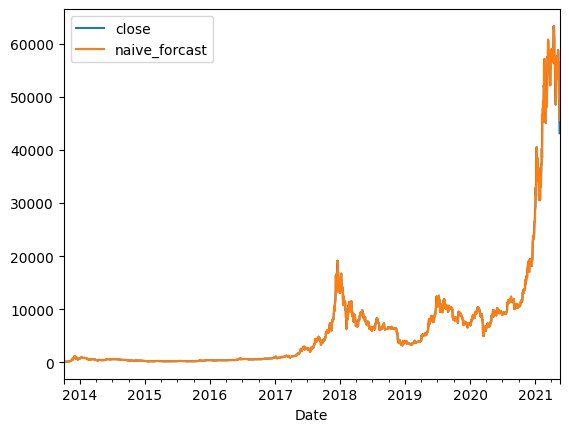

In [6]:
df.plot()

### Errors & Preprocessing

In [7]:
import tensorflow as tf
import numpy as np
# MSE Implementaion
def mse_scaled(y_true,y_pred):
  mae = tf.reduce_mean(tf.abs(y_pred - y_true))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return (mae / mae_naive_no_season).numpy()

In [8]:
mse_scaled(df['close'].to_numpy()[1:],df['naive_forcast'].to_numpy()[1:])

0.9996443298941867

In [9]:
close = df['close'].to_numpy()
close

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361, 43144.47129086])

In [10]:
WINDOW_SIZE = 7
HORIZON = 1
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [11]:
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):

  window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
  # print('window_step: ',window_step)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
  # print('window_indexes: ',window_indexes)
  windowed_array = x[window_indexes]
  return get_labelled_windows(windowed_array,horizon=HORIZON)

In [12]:
full_windows, full_labels = make_windows(close)

In [13]:
full_windows[-1], full_labels[-1],close[-1]

(array([55715.54665129, 56573.5554719 , 52147.82118698, 49764.1320816 ,
        50032.69313676, 47885.62525472, 45604.61575361]),
 array([43144.47129086]),
 43144.4712908603)

In [14]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [15]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Modeling Checkpoint

In [16]:
import os

def create_model_checkpoint(model_name,save_path='model_experiments'):

  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                            verbos=0,
                                            save_best_only=True)

### Model 1: Dense Model(window = 7, horizon = 1)

In [17]:
from tensorflow.keras import layers

model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON),

], name = 'model_1_dense')

model_1.compile(
    loss='mae',
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['mae','mse']
)

model_1.fit(
    x= train_windows,
    y= train_labels,
    epochs = 100,
    validation_data = (test_windows,test_labels),
    callbacks=[create_model_checkpoint(model_1.name)]
)

Epoch 1/100
70/70 [==============================] - 10s 37ms/step - loss: 915.9379 - mae: 915.9379 - mse: 5149031.5000 - val_loss: 982.3985 - val_mae: 982.3985 - val_mse: 2872395.7500
Epoch 2/100
70/70 [==============================] - 1s 14ms/step - loss: 160.7958 - mae: 160.7958 - mse: 137177.9062 - val_loss: 845.9932 - val_mae: 845.9932 - val_mse: 2410337.2500
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 149.8409 - mae: 149.8409 - mse: 123739.9453 - val_loss: 856.4218 - val_mae: 856.4218 - val_mse: 2260642.5000
Epoch 4/100
70/70 [==============================] - 1s 9ms/step - loss: 144.3622 - mae: 144.3622 - mse: 113166.5078 - val_loss: 802.0508 - val_mae: 802.0508 - val_mse: 2162412.2500
Epoch 5/100
70/70 [==============================] - 1s 9ms/step - loss: 148.5535 - mae: 148.5535 - mse: 114642.0469 - val_loss: 739.7382 - val_mae: 739.7382 - val_mse: 1841715.8750
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 144.8936 - ma

In [18]:
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 592.5790 - mae: 592.5790 - mse: 1219293.8750


[592.5789794921875, 592.5789794921875, 1219293.875]

In [19]:
#loading saved best performing model_1

model_1 = tf.keras.models.load_model('model_experiments/model_1_dense/')
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.8060 - mae: 568.8060 - mse: 1169189.5000


[568.8060302734375, 568.8060302734375, 1169189.5]

## Model 2: Dense(window = 30, horizon = 1)

In [20]:
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(close,WINDOW_SIZE,HORIZON)

In [21]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels,test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [22]:
train_windows[1]

array([125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
       123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
       135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
       160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
       175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499])

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
], name= 'model_2_dense')

model_2.compile(
    loss= 'mae',
    optimizer = 'adam',
    metrics = ['mae']
)

model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    validation_data=(test_windows,test_labels),
    callbacks=[create_model_checkpoint(model_2.name)]
)

Epoch 1/100
69/69 [==============================] - 1s 10ms/step - loss: 386.0298 - mae: 386.0298 - val_loss: 1477.9846 - val_mae: 1477.9846
Epoch 2/100
69/69 [==============================] - 0s 3ms/step - loss: 268.5357 - mae: 268.5357 - val_loss: 2085.2673 - val_mae: 2085.2673
Epoch 3/100
69/69 [==============================] - 1s 8ms/step - loss: 214.0211 - mae: 214.0211 - val_loss: 972.3812 - val_mae: 972.3812
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 185.6208 - mae: 185.6208 - val_loss: 1301.4138 - val_mae: 1301.4138
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 185.2944 - mae: 185.2944 - val_loss: 1613.1093 - val_mae: 1613.1093
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 172.8956 - mae: 172.8956 - val_loss: 860.4138 - val_mae: 860.4138
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 175.6284 - mae: 175.6284 - val_loss: 1298.2961 - val_mae: 1298.2961
Epoch 8/100
69/6

In [ ]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 582.0709 - mae: 582.0709


[582.0708618164062, 582.0708618164062]

### Model 3: (window=30, horizon=7)

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(close, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:

# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1218.0769


1218.076904296875

## model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(close, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
tf.constant(train_windows[0])

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))

In [ ]:
model_4 = tf.keras.Sequential([
    expand_dims_layer,
    layers.Conv1D(128,kernel_size=7,padding='causal',activation='relu'),
    # layers.Dense(128,activation='relu'),
    layers.Dense(1)
], name='model_4_conv1d')

model_4.compile(loss='mae',
                optimizer='adam',
                metrics=['mae'])

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_4.name)])

Epoch 1/100
70/70 [==============================] - 7s 20ms/step - loss: 586.2366 - mae: 586.2366 - val_loss: 1013.0925 - val_mae: 1013.0925
Epoch 2/100
70/70 [==============================] - 1s 14ms/step - loss: 178.7765 - mae: 178.7765 - val_loss: 1011.8588 - val_mae: 1011.8588
Epoch 3/100
70/70 [==============================] - 1s 11ms/step - loss: 174.6453 - mae: 174.6453 - val_loss: 989.2122 - val_mae: 989.2122
Epoch 4/100
70/70 [==============================] - 1s 11ms/step - loss: 167.0560 - mae: 167.0560 - val_loss: 874.7084 - val_mae: 874.7084
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 157.8309 - mae: 157.8309 - val_loss: 887.8199 - val_mae: 887.8199
Epoch 6/100
70/70 [==============================] - 1s 11ms/step - loss: 147.5566 - mae: 147.5566 - val_loss: 799.9576 - val_mae: 799.9576
Epoch 7/100
70/70 [==============================] - 1s 11ms/step - loss: 147.2278 - mae: 147.2278 - val_loss: 783.1838 - val_mae: 783.1838
Epoch 8/100
70/70

## Model 5: RNN(LSTM)

In [ ]:
inputs = layers.Input(shape=(7))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
# x = layers.LSTM(128,return_sequences=True)(x)
x = layers.LSTM(128,activation='relu')(x)
outputs = layers.Dense(1)(x)

model_5 = tf.keras.Model(inputs,outputs, name='model_5_LSTM')

model_5.compile(loss='mae',
                optimizer='adam')

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_5.name)])


Epoch 1/100
70/70 [==============================] - 4s 34ms/step - loss: 795.0340 - val_loss: 1205.2947
Epoch 2/100
70/70 [==============================] - 2s 25ms/step - loss: 195.0172 - val_loss: 1194.2030
Epoch 3/100
70/70 [==============================] - 2s 31ms/step - loss: 183.9606 - val_loss: 1022.3106
Epoch 4/100
70/70 [==============================] - 2s 35ms/step - loss: 178.8122 - val_loss: 946.9104
Epoch 5/100
70/70 [==============================] - 2s 25ms/step - loss: 174.3226 - val_loss: 904.7585
Epoch 6/100
70/70 [==============================] - 2s 25ms/step - loss: 159.2933 - val_loss: 864.6291
Epoch 7/100
70/70 [==============================] - 2s 31ms/step - loss: 156.1367 - val_loss: 857.8093
Epoch 8/100
70/70 [==============================] - 2s 25ms/step - loss: 150.0343 - val_loss: 792.5301
Epoch 9/100
70/70 [==============================] - 0s 6ms/step - loss: 149.8603 - val_loss: 817.4839
Epoch 10/100
70/70 [==============================] - 0s 5ms/s

### Make a multivariate time series dataset

In [ ]:

# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")


In [ ]:

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - df.index[0]).days
block_reward_3_days = (block_reward_4_datetime - df.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:

# Add block_reward column
bitcoin_prices_block = df.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,close,naive_forcast,block_reward
Date,,,
2013-10-01,123.65499,NaN,25
2013-10-02,125.45500,123.65499,25
2013-10-03,108.58483,125.45500,25
2013-10-04,118.67466,108.58483,25
2013-10-05,121.33866,118.67466,25


In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["close"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)


,close,naive_forcast,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,
2013-10-01,123.65499,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
X = bitcoin_prices_windowed.dropna().drop('close',axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['close'].astype(np.float32)

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])


Epoch 1/100
18/18 [==============================] - 1s 32ms/step - loss: 2824.4512 - val_loss: 4602.2725
Epoch 2/100
18/18 [==============================] - 0s 24ms/step - loss: 413.7203 - val_loss: 1297.7067
Epoch 3/100
18/18 [==============================] - 0s 23ms/step - loss: 234.1886 - val_loss: 1030.2893
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 187.5549 - val_loss: 1004.2718
Epoch 5/100
18/18 [==============================] - 0s 24ms/step - loss: 178.4228 - val_loss: 1004.2591
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 167.0426 - val_loss: 910.8497
Epoch 7/100
18/18 [==============================] - 0s 24ms/step - loss: 158.8567 - val_loss: 871.3331
Epoch 8/100
18/18 [==============================] - 0s 24ms/step - loss: 156.1017 - val_loss: 845.8373
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 152.8222 - val_loss: 866.2369
Epoch 10/100
18/18 [==============================] - 0s 23

## Model 7: N-Beats Algorithm

#### Building and testing the N-beats

In [25]:
# Create NBeatsBlock custom layer
from tensorflow.keras import layers

class LSTMBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.Sequential([
        tf.keras.layers.Dense(theta_size, activation="linear", name="theta"),
        layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
        layers.LSTM(self.theta_size, return_sequences=True),
        layers.LSTM(self.theta_size, activation='relu')
    ])




  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [33]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = LSTMBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = LSTMBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

CPU times: user 1h 19min 6s, sys: 3min 48s, total: 1h 22min 54s
Wall time: 1h 11min 19s


In [34]:
model_7.evaluate(test_dataset)
# - mae: 4.8092 - mse: 392.8146 - val_loss: 701.8333 - val_mae: 701.8333 - val_mse: 1659019.3750

1/1 [==============================] - 0s 89ms/step - loss: 18956.6133 - mae: 18956.6133 - mse: 667850752.0000


[18956.61328125, 18956.61328125, 667850752.0]

In [35]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers with relu activation

    self.hidden = [tf.keras.layers.Dense(n_neurons,activation='relu')] * n_layers
    print(self.hidden)
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation='linear',name='theta')


  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forcast = theta[:, :self.input_size], theta[: , -self.horizon:]
    return backcast, forcast


In [36]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [37]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                      theta_size=WINDOW_SIZE+HORIZON,
                                      horizon= HORIZON,
                                      n_neurons=128,
                                      n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims([[1,3,3,3,3,2,4],
                [1,3,3,3,3,2,4]],axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 2, 7), dtype=int32, numpy=
array([[[1, 3, 3, 3, 3, 2, 4],
        [1, 3, 3, 3, 3, 2, 4]]], dtype=int32)>

In [ ]:
tf.expand_dims([[1,3,3,3,3,2,4],
                [1,3,3,3,3,2,4]],axis=0)

<tf.Tensor: shape=(1, 2, 7), dtype=int32, numpy=
array([[[1, 3, 3, 3, 3, 2, 4],
        [1, 3, 3, 3, 3, 2, 4]]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

In [ ]:
tf.squeeze(backcast)

<tf.Tensor: shape=(2, 8), dtype=float32, numpy=
array([[ 0.08377456,  0.17603081, -0.62094903, -0.02074429, -0.20383522,
        -0.00277201,  0.09264332,  0.8163265 ],
       [ 0.08377456,  0.17603081, -0.62094903, -0.02074429, -0.20383522,
        -0.00277201,  0.09264332,  0.8163265 ]], dtype=float32)>

In [ ]:
forecast

<tf.Tensor: shape=(1, 1, 8), dtype=float32, numpy=
array([[[ 0.08377456,  0.17603081, -0.62094903, -0.02074429,
         -0.20383522, -0.00277201,  0.09264332,  0.8163265 ]]],
      dtype=float32)>

### Data Pipline

In [26]:
HORIZON = 1
WINDOWS = 7

In [27]:
# Add windowed columns
bitcoin_prices_nbeats = df.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["close"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()


,close,naive_forcast,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,Price+8,...,Price+21,Price+22,Price+23,Price+24,Price+25,Price+26,Price+27,Price+28,Price+29,Price+30
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-31,196.02499,197.40000,197.40000,192.75666,187.15983,177.69650,175.03166,180.35500,200.70166,188.29716,...,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-11-01,198.04883,196.02499,196.02499,197.40000,192.75666,187.15983,177.69650,175.03166,180.35500,200.70166,...,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-11-02,198.93233,198.04883,198.04883,196.02499,197.40000,192.75666,187.15983,177.69650,175.03166,180.35500,...,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-11-03,200.54300,198.93233,198.93233,198.04883,196.02499,197.40000,192.75666,187.15983,177.69650,175.03166,...,126.38333,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-11-04,210.30750,200.54300,200.54300,198.93233,198.04883,196.02499,197.40000,192.75666,187.15983,177.69650,...,135.24199,126.38333,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [28]:

# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop(["close",'naive_forcast'], axis=1)
y = bitcoin_prices_nbeats.dropna()["close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2205, 2205, 552, 552)

In [29]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2205, 2205, 552, 552)

In [30]:

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 30), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 30), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [32]:

# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE


(30, 31)

In [38]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            #verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
3/3 [==============================] - 47s 858ms/step - loss: 193941.1562 - mae: 193941.1562 - mse: 117992177664.0000 - val_loss: 48514.5508 - val_mae: 48514.5508 - val_mse: 4182498048.0000 - lr: 0.0010
Epoch 2/5000
3/3 [==============================] - 0s 153ms/step - loss: 6161.7891 - mae: 6161.7891 - mse: 103863296.0000 - val_loss: 46559.9883 - val_mae: 46559.9883 - val_mse: 3839425024.0000 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 156ms/step - loss: 11352.2979 - mae: 11352.2979 - mse: 368142176.0000 - val_loss: 11896.5420 - val_mae: 11896.5420 - val_mse: 262442496.0000 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 169ms/step - loss: 1717.7737 - mae: 1717.7737 - mse: 21745574.0000 - val_loss: 2640.3672 - val_mae: 2640.3672 - val_mse: 17690814.0000 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - 0s 90ms/step - loss: 1128.7966 - mae: 1128.7966 - mse: 3730246.5000 - val_loss: 9573.6523 - val_mae: 9573.6523 -

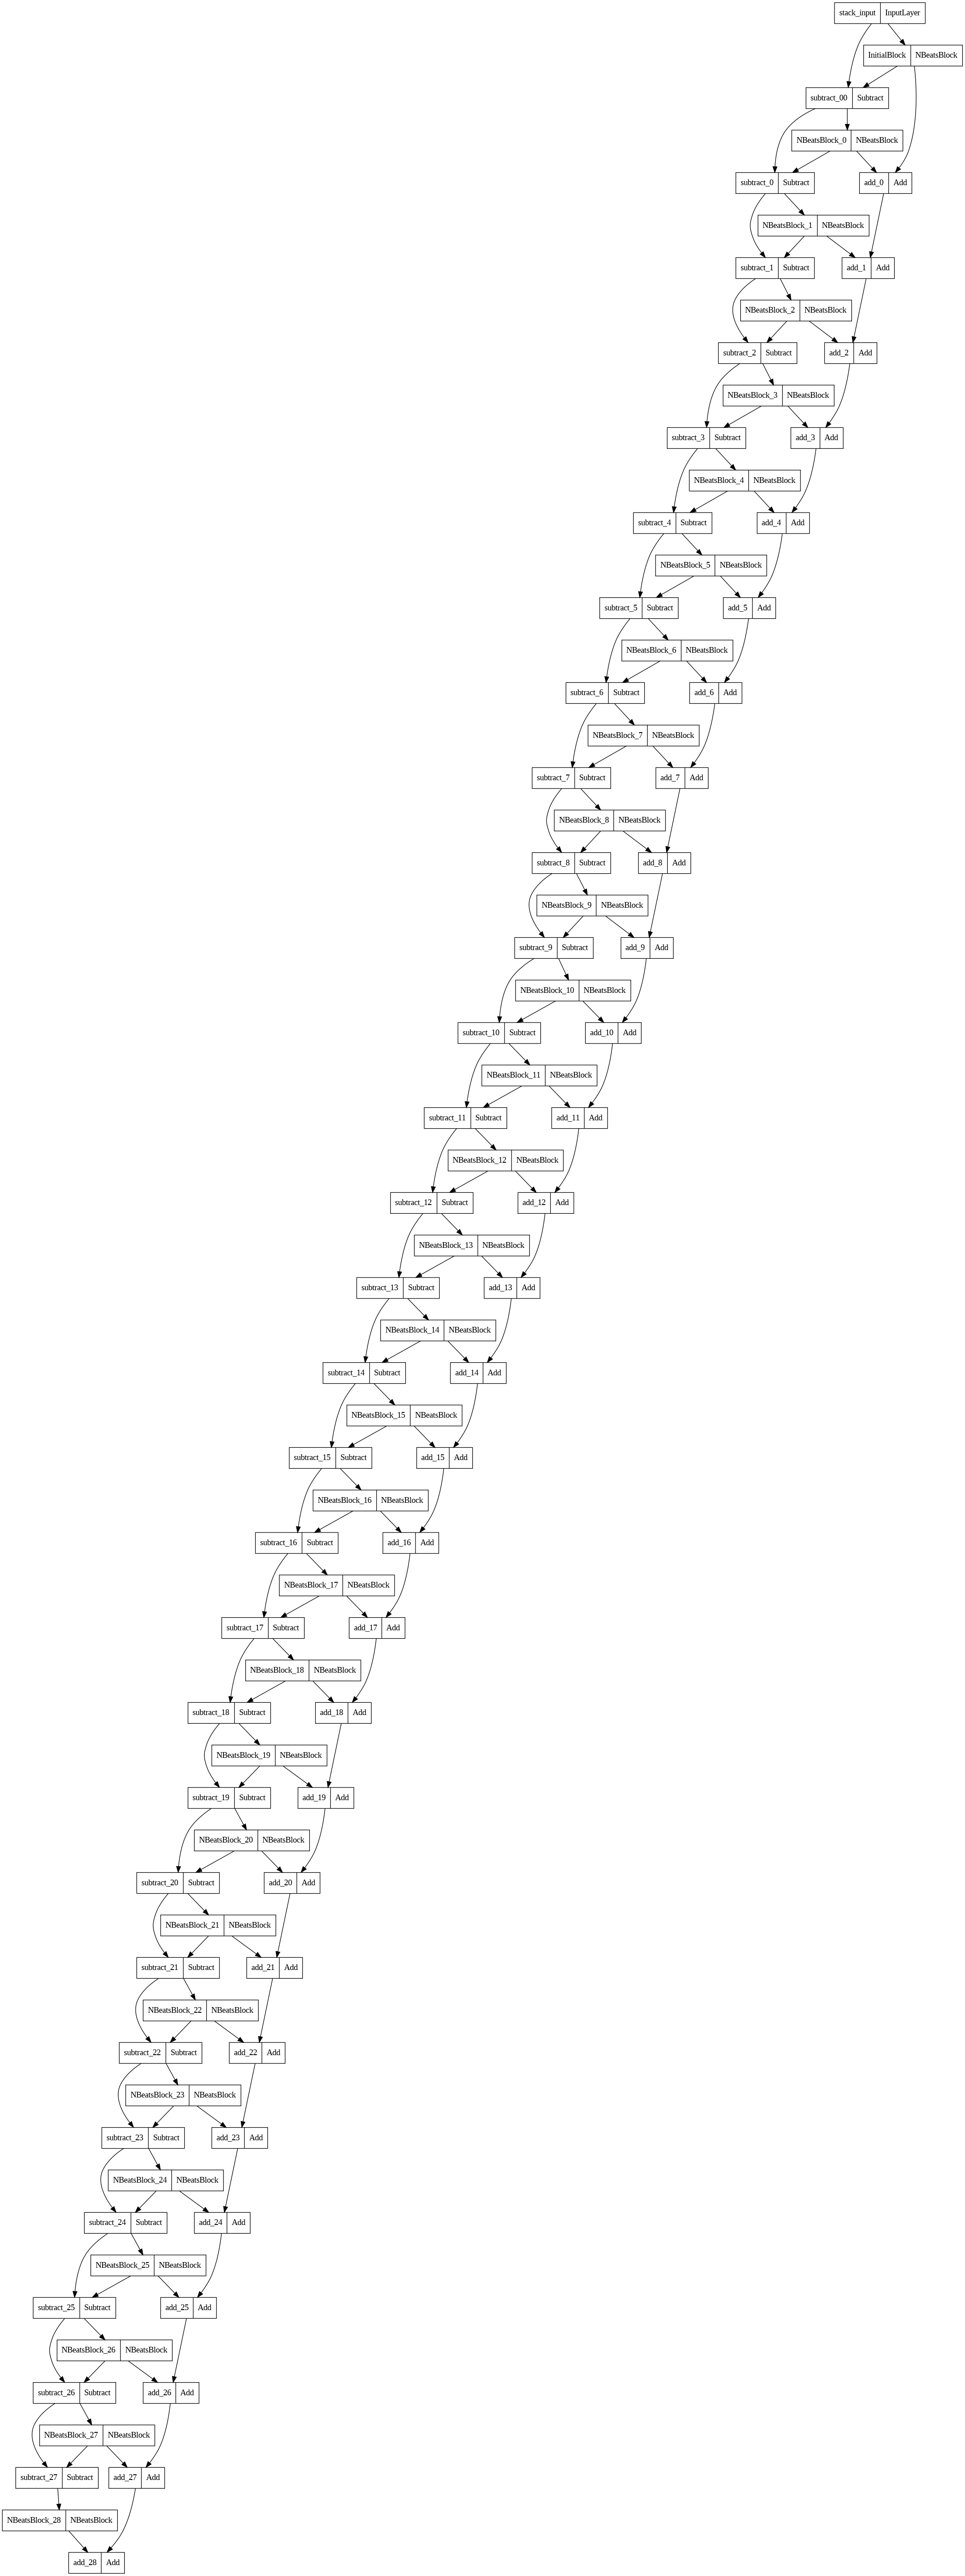

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Ensemble

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 477: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 734: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 834: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 504: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 604: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 510: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 610: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 245: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 925:

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:

# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 57ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8714.801 ,  8674.62  ,  8960.576 , ..., 51139.61  , 48754.633 ,
        45965.242 ],
       [ 8775.984 ,  8719.4795,  8993.622 , ..., 49813.63  , 48254.39  ,
        45479.457 ],
       [ 8807.2705,  8801.075 ,  9053.274 , ..., 50090.824 , 48560.484 ,
        45492.69  ],
       ...,
       [ 8808.783 ,  8773.433 ,  9035.08  , ..., 50344.52  , 49002.625 ,
        45861.59  ],
       [ 8733.742 ,  8751.512 ,  9075.088 , ..., 50028.188 , 49013.31  ,
        46202.84  ],
       [ 8803.526 ,  8777.045 ,  9077.378 , ..., 50456.574 , 48354.273 ,
        46203.152 ]], dtype=float32)>

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

NameError: ignored

In [ ]:
bitcoin_prices_windowed.head()


,close,naive_forcast,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,
2013-10-01,123.65499,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:

# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["close", "block_reward",'naive_forcast'], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["close"].to_numpy()


In [ ]:

# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
model_9 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(HORIZON)
])

model_9.compile(
    loss='mae',
    optimizer='adam'
)

model_9.fit(
    dataset_all,
    epochs=100
)

Epoch 1/100
3/3 [==============================] - 1s 7ms/step - loss: 1866.1007
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 562.8461
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 596.4098
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 448.6191
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 449.4175
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 379.6169
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 372.5576
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 352.9736
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 303.3497
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 338.3570
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 312.3062
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 276.0762
Epoch 13/100
3/3 [==================

In [ ]:
INTO_FUTURE = 14